<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-nnqf.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-nnqf.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb&fileName=gefcom14-s-nnqf"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Download data

In [ ]:
!echo "Downloading GEFCom14-S..."
!rm -R data > /dev/null
!wget -O gefcom14.zip https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0
!unzip gefcom14 > /dev/null
!rm gefcom14.zip > /dev/null
!unzip GEFCom2014\ Data/GEFCom2014-S_V2.zip > /dev/null
!rm -R GEFCom2014\ Data > /dev/null
!mv Solar data > /dev/null
!echo "------------------------------"
!echo "Downloaded GEFCom14-S in data/"

# Select Task

In [2]:
task = 10
assert task < 15

# Prepare data

In [3]:
import numpy as np
import pandas as pd

# only use surface solar radiation (169), surface thermal radiation (175) and top net solar radiation (178)
predictors = pd.read_csv(f'data/Task {task}/predictors{task}.csv', parse_dates=['TIMESTAMP'])\
    [['ZONEID', 'TIMESTAMP', 'VAR169', 'VAR175', 'VAR178']].set_index('TIMESTAMP')
train = pd.read_csv(f'data/Task {task + 1}/train{task + 1}.csv', parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')
benchmark = pd.read_csv(f"data/Task {task}/benchmark{'0' + str(task) if task < 10 else task}.csv",
                        parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')

solar_plants = [train[train['ZONEID'] == i][['POWER']].rename({'POWER': f'ZONEID {i}'}, axis='columns')
                for i in [1,2,3]]
train_data = pd.concat(solar_plants, axis=1)

predictors_categories = [predictors[predictors['ZONEID'] == i][['VAR169', 'VAR175', 'VAR178']]
                             .rename({'VAR169': f'SURFACE SOLAR RADIATION {i}',
                                      'VAR175': f'SURFACE THERMAL RADIATION {i}',
                                      'VAR178': f'TOP NET SOLAR RADIATION {i}'}, axis='columns')
                         for i in [1,2,3]]
predictor_data = pd.concat(predictors_categories, axis=1)

In [4]:
gefcom14_metadata = {
    'num_series': 3,
    'num_steps': len(predictor_data),
    'prediction_length': len(benchmark) // 3,
    'start': predictor_data.index[0]
}

In [5]:
for i in range(1, 4):
    predictor_data[f'SURFACE SOLAR RADIATION {i}'] /= predictor_data[f'SURFACE SOLAR RADIATION {i}'].max()
    predictor_data[f'SURFACE THERMAL RADIATION {i}'] /= predictor_data[f'SURFACE THERMAL RADIATION {i}'].max()
    predictor_data[f'TOP NET SOLAR RADIATION {i}'] /= predictor_data[f'TOP NET SOLAR RADIATION {i}'].max()

In [6]:
predictor1 = predictor_data[['SURFACE SOLAR RADIATION 1', 'SURFACE THERMAL RADIATION 1', 'TOP NET SOLAR RADIATION 1']]

train_data1 = train_data[['ZONEID 1']]

In [7]:
x_input_df = predictor1[:-gefcom14_metadata['prediction_length']]
x_input = np.array(x_input_df)
y_output = np.array(train_data1[:-gefcom14_metadata['prediction_length']])

In [8]:
import numpy as np
from sklearn.neighbors import NearestNeighbors as nn_fun

def nnqf_filter(x_input, 
                y_output, 
                num_neighbors = 10, 
                q_quantile = 0.5, 
                var_weighting = True, 
                minkowski_dist = 2):
    """
    Parameters
    ----------
    x_input : numpy array ;
    Input matrix of dimension (N,S), with N representing the number of
    samples and S the number of features

    y_output : numpy array ;
    Output vector of dimension (N,)

    num_neighbors : int, default = 10 ;
    Number of nearest neighbors that the filter is going to search for     

    q_quantile : float, default = 0.5 ;
    Must be a value between 0 and 1. 
    Probability of the quantile that is going to be calculated from the 
    nearest neighbors output values      

    var_weighting : bool, default = True ;
    Value defining if the columns of the input matrix are going to be multiplied 
    by the inverse of their variance

    minkowski_dist : int, default = 2 ;
    Parameter used to define the type of minkoswki distance used to calculate 
    the nearest neighbors

    Returns
    -------
    yq_output : numpy array ;
    New output vector containing the quantiles of the output values of the
    input's nearest neighbors

    """
    # --
    # Each column of the input matrix is multiplied by the inverse of its variance, 
    # in order to avoid a feature with a huge scale to overpower the others at the 
    # moment of calculating the distances

    if var_weighting:
        var_weights = np.var(x_input, axis=0)
        x_input = var_weights ** (-1) * x_input    

    # --
    # We calculate the nearest neighbor of each feature vector within the input matrix
    # and obtain their corresponding indices
    # The distance used is the minkowski distance with p = minkowski_dist

    x_neighbors = nn_fun(n_neighbors=num_neighbors, algorithm='auto', p=minkowski_dist).fit(x_input)
    dist, indx = x_neighbors.kneighbors(x_input)


    # --
    # We create a matrix containing the output values of nearest neighbors of
    # each input vector

    y_neighbors = y_output[indx[0,:]].T
    for i in range(1, np.size(x_input, 0)):
        values_to_add = y_output[indx[i,:]].T
        y_neighbors = np.vstack([y_neighbors, values_to_add])

    # --
    # We calculate the q_quantile of the nearest neighbors output values
    # and create with them a new output vector yq_output

    yq_output = np.quantile(y_neighbors, q=q_quantile, axis=1)
        
    return yq_output

In [9]:
yq_output = nnqf_filter(x_input=x_input, y_output=y_output, 
                        q_quantile=[p / 100 for p in range(1, 100)]).T

yq_output.shape

(15360, 99)

In [10]:
yq_output_df = pd.DataFrame(yq_output, index=x_input_df.index)\
    .rename(columns={p: str((p+1)/100) for p in range(99)})
yq_output_df

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.4,...,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.7,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.8,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-04-01 01:00:00,0.555426,0.562840,0.570253,0.577667,0.585080,0.592494,0.599907,0.607321,0.614734,0.622147,0.629561,0.633133,0.636226,0.639318,0.642410,0.645503,0.648595,0.651687,0.654779,0.657872,0.660964,0.664056,0.670999,0.679041,0.687083,0.695126,0.703168,0.711210,0.719253,0.727295,0.735337,0.743379,0.751422,0.754253,0.754478,0.754703,0.754928,0.755153,0.755378,0.755603,...,0.772679,0.773787,0.774895,0.776003,0.777110,0.778218,0.779326,0.780085,0.780149,0.780212,0.780276,0.780339,0.780403,0.780466,0.780529,0.780593,0.780656,0.780720,0.781381,0.784133,0.786885,0.789637,0.792388,0.795140,0.797892,0.800644,0.803396,0.806148,0.808900,0.811371,0.811596,0.811821,0.812046,0.812271,0.812496,0.812721,0.812946,0.813171,0.813396,0.813621
2012-04-01 02:00:00,0.132144,0.163967,0.195790,0.227613,0.259436,0.291259,0.323082,0.354905,0.386728,0.418551,0.450374,0.458572,0.463816,0.469060,0.474304,0.479549,0.484793,0.490037,0.495281,0.500526,0.505770,0.511014,0.515177,0.519031,0.522885,0.526738,0.530592,0.534446,0.538300,0.542154,0.546008,0.549862,0.553715,0.561631,0.571577,0.581523,0.591469,0.601415,0.611362,0.621308,...,0.669551,0.669724,0.669897,0.670071,0.670244,0.670417,0.670590,0.670765,0.670944,0.671122,0.671301,0.671480,0.671659,0.671838,0.672017,0.672196,0.672374,0.672553,0.673755,0.678538,0.683321,0.688103,0.692886,0.697669,0.702451,0.707234,0.712017,0.716799,0.721582,0.726372,0.731224,0.736076,0.740928,0.745780,0.750632,0.755484,0.760336,0.765188,0.770040,0.774892
2012-04-01 03:00:00,0.379756,0.383165,0.386575,0.389985,0.393394,0.396804,0.400213,0.403623,0.407033,0.410442,0.413852,0.416164,0.418339,0.420514,0.422689,0.424864,0.427039,0.429214,0.431389,0.433564,0.435739,0.437914,0.442153,0.446982,0.451811,0.456640,0.461469,0.466297,0.471126,0.475955,0.480784,0.485613,0.490442,0.492517,0.493215,0.493913,0.494611,0.495309,0.496007,0.496705,...,0.532846,0.538073,0.543300,0.548527,0.553754,0.558981,0.564208,0.571735,0.583862,0.595988,0.608115,0.620242,0.632369,0.644496,0.656623,0.668750,0.680877,0.693004,0.703227,0.706787,0.710346,0.713906,0.717465,0.721025,0.724585,0.728144,0.731704,0.735263,0.738823,0.742092,0.743032,0.743972,0.744913,0.745853,0.746794,0.747734,0.748674,0.749615,0.750555,0.751496
2012-04-01 04:00:00,0.013207,0.026286,0.039365,0.052444,0.065522,0.078601,0.091680,0.104759,0.117838,0.130917,0.143996,0.164603,0.186151,0.207699,0.229247,0.250795,0.272343,0.293891,0.315439,0.336987,0.358535,0.380083,0.387986,0.391990,0.395994,0.399997,0.404001,0.408005,0.412009,0.416013,0.420017,0.424021,0.428024,0.433851,0.440590,0.447328,0.454067,0.460805,0.467544,0.474282,...,0.544346,0.551656,0.558965,0.566275,0.573585,0.580894,0.588204,0.593421,0.594454,0.595487,0.596519,0.597552,0.598585,0.599617,0.600650,0.601683,0.602715,0.603748,0.604836,0.606117,0.607397,0.608678,0.609959,0.611240,0.612521,0.613801,0.615082,0.616363,0.617644,0.618947,0.620429,0.621912,0.623395,0.624878,0.626360,0.627843,0.629326,0.630808,0.632291,0.633774
2012-04-01 05:00:00,0.101178,0.101714,0.102251,0.102787,0.103324,0.103860,0.104397,0.104933,0.105470,0.106006,0.106543,0.107033,0.107518,0.108003,0.108487,0.108972,0.109456,0.109941,0.110426,0.110910,0.111395,0.111879,0.112665,0.113536,0.114407,0.115278,0.116149,0.117021,0.117892,0.118763,0.119634,0.120505,0.121376,0.121667,0.121667,0.121667,0.121667,0.121667,0.121667,0.121667,...,0.217731,0.220696,0.223662,0.226627,0.229592,0.232558,0.235523,0.239356,0.244923,0.250490,0.256058,0.261625,0.267192,0.272760,0.278327,0.283894,0.289462

# Train the linear regression model (ANN10)

In [11]:
import pandas as pd
from sklearn import preprocessing

# normalize predictor values
x = predictor1.values
min_max_scaler = preprocessing.MinMaxScaler()
scaled = min_max_scaler.fit_transform(x)
predictor1 = pd.DataFrame(scaled)
predictor1

,0,1,2
0,0.069952,0.010104,0.060313
1,0.151267,0.047458,0.144804
2,0.226360,0.084522,0.226618
3,0.283103,0.121753,0.292088
4,0.320642,0.161768,0.340629
...,...,...,...
16099,0.594482,0.763988,0.639860
16100,0.612984,0.800668,0.662648
16101,0.654841,0.838171,0.709289
16102,0.719681,0.876778,0.778376


## Prepare data for regression model

In [12]:
h = 24
h1 = 24

data = predictor1
x_pieces = []
for i in range(h1):
    piece = data.drop(range(i)).reset_index().drop('index', axis=1)
    x_pieces.insert(0, piece)

x = pd.concat(x_pieces, axis=1)
x.index = x.index.map(lambda x: x + h1 - 1)
x = x[:-h+1]
x

,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2
23,0.447132,0.837689,0.507297,0.403251,0.796552,0.455890,0.373454,0.758559,0.419290,0.357943,0.721684,0.399047,0.356004,0.688225,0.395550,0.356004,0.653056,0.395550,0.356004,0.617071,0.395550,0.356004,0.581265,0.395550,0.356004,0.546830,0.395550,0.356004,0.514069,0.395550,0.356004,0.481723,0.395550,0.356004,0.448947,0.395550,0.356004,0.416056,0.395550,0.356004,0.382292,0.395550,0.356004,0.348075,0.395561,0.356004,0.311964,0.395561,0.356004,0.275454,0.395561,0.353759,0.238150,0.390427,0.340330,0.200918,0.370537,0.320642,0.161768,0.340629,0.283103,0.121753,0.292088,0.226360,0.084522,0.226618,0.151267,0.047458,0.144804,0.069952,0.010104,0.060313
24,0.044781,0.013434,0.041686,0.447132,0.837689,0.507297,0.403251,0.796552,0.455890,0.373454,0.758559,0.419290,0.357943,0.721684,0.399047,0.356004,0.688225,0.395550,0.356004,0.653056,0.395550,0.356004,0.617071,0.395550,0.356004,0.581265,0.395550,0.356004,0.546830,0.395550,0.356004,0.514069,0.395550,0.356004,0.481723,0.395550,0.356004,0.448947,0.395550,0.356004,0.416056,0.395550,0.356004,0.382292,0.395550,0.356004,0.348075,0.395561,0.356004,0.311964,0.395561,0.356004,0.275454,0.395561,0.353759,0.238150,0.390427,0.340330,0.200918,0.370537,0.320642,0.161768,0.340629,0.283103,0.121753,0.292088,0.226360,0.084522,0.226618,0.151267,0.047458,0.144804
25,0.091851,0.053876,0.100291,0.044781,0.013434,0.041686,0.447132,0.837689,0.507297,0.403251,0.796552,0.455890,0.373454,0.758559,0.419290,0.357943,0.721684,0.399047,0.356004,0.688225,0.395550,0.356004,0.653056,0.395550,0.356004,0.617071,0.395550,0.356004,0.581265,0.395550,0.356004,0.546830,0.395550,0.356004,0.514069,0.395550,0.356004,0.481723,0.395550,0.356004,0.448947,0.395550,0.356004,0.416056,0.395550,0.356004,0.382292,0.395550,0.356004,0.348075,0.395561,0.356004,0.311964,0.395561,0.356004,0.275454,0.395561,0.353759,0.238150,0.390427,0.340330,0.200918,0.370537,0.320642,0.161768,0.340629,0.283103,0.121753,0.292088,0.226360,0.084522,0.226618
26,0.144585,0.095325,0.162639,0.091851,0.053876,0.100291,0.044781,0.013434,0.041686,0.447132,0.837689,0.507297,0.403251,0.796552,0.455890,0.373454,0.758559,0.419290,0.357943,0.721684,0.399047,0.356004,0.688225,0.395550,0.356004,0.653056,0.395550,0.356004,0.617071,0.395550,0.356004,0.581265,0.395550,0.356004,0.546830,0.395550,0.356004,0.514069,0.395550,0.356004,0.481723,0.395550,0.356004,0.448947,0.395550,0.356004,0.416056,0.395550,0.356004,0.382292,0.395550,0.356004,0.348075,0.395561,0.356004,0.311964,0.395561,0.356004,0.275454,0.395561,0.353759,0.238150,0.390427,0.340330,0.200918,0.370537,0.320642,0.161768,0.340629,0.283103,0.121753,0.292088
27,0.197453,0.135820,0.224146,0.144585,0.095325,0.162639,0.091851,0.053876,0.100291,0.044781,0.013434,0.041686,0.447132,0.837689,0.507297,0.403251,0.796552,0.455890,0.373454,0.758559,0.419290,0.357943,0.721684,0.399047,0.356004,0.688225,0.395550,0.356004,0.653056,0.395550,0.356004,0.617071,0.395550,0.356004,0.581265,0.395550,0.356004,0.546830,0.395550,0.356004,0.514069,0.395550,0.356004,0.481723,0.395550,0.356004,0.448947,0.395550,0.356004,0.416056,0.395550,0.356004,0.382292,0.395550,0.356004,0.348075,0.395561,0.356004,0.311964,0.395561,0.356004,0.275454,0.395561,0.353759,0.238150,0.390427,0.340330,0.200918,0.370537,0.320642,0.161768,0.340629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16099,0.594482,0.763988,0.639860,0.592938,0.728563,0.637056,0.592938,0.692981,0.637056,0.592938,0.657168,0.637056,0.592938,0.621120,0.637056,0.592938,0.584747,0.637056,0.592938,0.547937,0.637056,0.592938,0.510535,0.637056,0.592938,0.472209,0.637056,0.592938,0.433495,0.637056,0.592938,0.394410,0.637056,0.592

In [13]:
from sklearn.neural_network import MLPRegressor
from tqdm import tqdm

ensemble_size = 20

predictions = [pd.DataFrame() for _ in range(ensemble_size)]

for p in tqdm(range(1, 100)):
    for i in range(ensemble_size):
        y = yq_output_df.reset_index().drop('TIMESTAMP', axis=1).drop(range(h1-1))[str(p/100)]
        model = MLPRegressor(hidden_layer_sizes=(6,))

        trained = model.fit(x[:-gefcom14_metadata['prediction_length']], y)
        predictions[i].insert(p-1, str(p/100), trained.predict(x[-gefcom14_metadata['prediction_length']:]))

100%|██████████| 99/99 [38:50<00:00, 23.54s/it]


In [14]:
# ensemble averaging

averaged_predictions = pd.DataFrame()

for p in range(1, 100):
    quantile_columns = [prediction[str(p/100)] for prediction in predictions]
    averaged_predictions.insert(p-1, str(p/100), np.average(quantile_columns, axis=0))
averaged_predictions

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.4,...,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.7,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.8,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
0,0.593380,0.623636,0.617974,0.631232,0.649110,0.661690,0.660167,0.704952,0.699807,0.718439,0.714892,0.709569,0.725600,0.751164,0.727971,0.708812,0.748750,0.736284,0.762753,0.785103,0.763223,0.786060,0.763137,0.761572,0.778649,0.772905,0.784506,0.767143,0.772683,0.711579,0.793678,0.790055,0.802574,0.768132,0.782139,0.799585,0.824910,0.794385,0.758990,0.852145,...,0.855598,0.854075,0.868240,0.850491,0.839381,0.839430,0.854097,0.844843,0.865920,0.869147,0.868179,0.850438,0.868650,0.856833,0.873208,0.832566,0.871164,0.854693,0.864732,0.858779,0.835849,0.836830,0.882189,0.880918,0.865541,0.845062,0.863758,0.849113,0.860039,0.852085,0.868112,0.852282,0.863717,0.856229,0.881920,0.869577,0.836429,0.883575,0.884773,0.897374
1,0.547791,0.569604,0.585188,0.567134,0.586938,0.608154,0.609319,0.614663,0.616983,0.649765,0.645637,0.626008,0.675697,0.647334,0.659021,0.647510,0.692717,0.675749,0.720325,0.704629,0.705382,0.721729,0.694412,0.716712,0.717751,0.707329,0.726796,0.710650,0.722506,0.667983,0.734874,0.713830,0.753135,0.714406,0.726264,0.729094,0.764903,0.740534,0.709914,0.776115,...,0.784231,0.785814,0.805208,0.793824,0.777009,0.805896,0.801122,0.789868,0.813825,0.814205,0.812267,0.797981,0.823371,0.807212,0.830081,0.790902,0.829686,0.809991,0.837080,0.819592,0.806362,0.809308,0.835003,0.839328,0.841206,0.813714,0.830911,0.828586,0.838028,0.823633,0.829113,0.825310,0.829042,0.831011,0.865430,0.855752,0.821502,0.863386,0.847897,0.865298
2,0.471229,0.491804,0.491293,0.489341,0.505246,0.516491,0.525852,0.515490,0.517126,0.562144,0.547389,0.521082,0.581412,0.520318,0.557027,0.552163,0.573805,0.572010,0.610720,0.577806,0.592768,0.602549,0.574400,0.598496,0.582826,0.577711,0.608283,0.593849,0.620267,0.573543,0.608986,0.602185,0.626305,0.593549,0.595039,0.622445,0.647854,0.632557,0.604173,0.657505,...,0.669495,0.697236,0.718193,0.696207,0.710769,0.709867,0.698181,0.692558,0.719470,0.724148,0.707539,0.722125,0.730702,0.713701,0.729503,0.709414,0.743532,0.727632,0.736294,0.729873,0.742224,0.742070,0.740975,0.732415,0.743924,0.741554,0.746367,0.745833,0.762550,0.749758,0.748682,0.757679,0.736306,0.739108,0.786630,0.778073,0.737836,0.777552,0.768242,0.795386
3,0.337875,0.380974,0.357806,0.368395,0.386639,0.370726,0.403839,0.354825,0.349346,0.396050,0.393723,0.365611,0.425724,0.331838,0.402976,0.397430,0.406895,0.425798,0.454081,0.412544,0.420304,0.447277,0.396966,0.435793,0.403934,0.399770,0.464159,0.452770,0.453021,0.446625,0.431389,0.458138,0.477921,0.433551,0.421036,0.476009,0.499726,0.471849,0.474949,0.491991,...,0.523855,0.559828,0.570660,0.552762,0.555152,0.580514,0.559527,0.567844,0.577287,0.584434,0.554798,0.593956,0.576189,0.574270,0.593600,0.564975,0.622671,0.602338,0.600479,0.593614,0.611429,0.621275,0.618968,0.602572,0.604862,0.593680,0.629564,0.608893,0.647147,0.627491,0.605064,0.645588,0.612310,0.620407,0.657073,0.668083,0.628408,0.652054,0.657646,0.659272
4,0.153493,0.176660,0.169166,0.176224,0.195166,0.162407,0.211764,0.148530,0.132235,0.184101,0.184683,0.180482,0.223577,0.153225,0.192859,0.194359,0.192977,0.216346,0.244696,0.233501,0.218529,0.221197,0.216387,0.237625,0.225607,0.245697,0.277835,0.258587,0.237298,0.264654,0.233230,0.279563,0.275596,0.257181,0.207916,0.299492,0.305621,0.282434,0.291191,0.305941,...,0.371529,0.378608,0.397216,0.383377,0.366350,0.421183,0.371673,0.401269,0.402479,0.404489,0.419532,0.423390,0.415587,0.424380,0.407115,0.408303,0.473012,0.430056,0.447963,0.430443,0.446006,0.465135,0.480544,0.456400,0.465266,0.432698,0.457396,0.465229,0.491501,0.495604,0.458711,0.517908,0.463138,0.479016,0.518639,0.531690,0.500609,

# Postprocessing: Remove quantile crossing

In [15]:
# sorting
# prediction = np.maximum(prediction, 0)
# prediction.values.sort()
# prediction

In [16]:
# maximum

prediction = averaged_predictions
prediction['0.01'] = np.maximum(prediction['0.01'], 0)
for p in range(2, 100):
    prediction[str(p/100)] = np.maximum(prediction[str((p-1)/100)], prediction[str(p/100)])
averaged_predictions

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.4,...,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.7,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.8,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
0,0.593380,0.623636,0.623636,0.631232,0.649110,0.661690,0.661690,0.704952,0.704952,0.718439,0.718439,0.718439,0.725600,0.751164,0.751164,0.751164,0.751164,0.751164,0.762753,0.785103,0.785103,0.786060,0.786060,0.786060,0.786060,0.786060,0.786060,0.786060,0.786060,0.786060,0.793678,0.793678,0.802574,0.802574,0.802574,0.802574,0.824910,0.824910,0.824910,0.852145,...,0.858333,0.858333,0.868240,0.868240,0.868240,0.868240,0.868240,0.868240,0.868240,0.869147,0.869147,0.869147,0.869147,0.869147,0.873208,0.873208,0.873208,0.873208,0.873208,0.873208,0.873208,0.873208,0.882189,0.882189,0.882189,0.882189,0.882189,0.882189,0.882189,0.882189,0.882189,0.882189,0.882189,0.882189,0.882189,0.882189,0.882189,0.883575,0.884773,0.897374
1,0.547791,0.569604,0.585188,0.585188,0.586938,0.608154,0.609319,0.614663,0.616983,0.649765,0.649765,0.649765,0.675697,0.675697,0.675697,0.675697,0.692717,0.692717,0.720325,0.720325,0.720325,0.721729,0.721729,0.721729,0.721729,0.721729,0.726796,0.726796,0.726796,0.726796,0.734874,0.734874,0.753135,0.753135,0.753135,0.753135,0.764903,0.764903,0.764903,0.776115,...,0.800373,0.800373,0.805208,0.805208,0.805208,0.805896,0.805896,0.805896,0.813825,0.814205,0.814205,0.814205,0.823371,0.823371,0.830081,0.830081,0.830081,0.830081,0.837080,0.837080,0.837080,0.837080,0.837080,0.839328,0.841206,0.841206,0.841206,0.841206,0.841206,0.841206,0.841206,0.841206,0.841206,0.841206,0.865430,0.865430,0.865430,0.865430,0.865430,0.865430
2,0.471229,0.491804,0.491804,0.491804,0.505246,0.516491,0.525852,0.525852,0.525852,0.562144,0.562144,0.562144,0.581412,0.581412,0.581412,0.581412,0.581412,0.581412,0.610720,0.610720,0.610720,0.610720,0.610720,0.610720,0.610720,0.610720,0.610720,0.610720,0.620267,0.620267,0.620267,0.620267,0.626305,0.626305,0.626305,0.626305,0.647854,0.647854,0.647854,0.657505,...,0.711119,0.711119,0.718193,0.718193,0.718193,0.718193,0.718193,0.718193,0.719470,0.724148,0.724148,0.724148,0.730702,0.730702,0.730702,0.730702,0.743532,0.743532,0.743532,0.743532,0.743532,0.743532,0.743532,0.743532,0.743924,0.743924,0.746367,0.746367,0.762550,0.762550,0.762550,0.762550,0.762550,0.762550,0.786630,0.786630,0.786630,0.786630,0.786630,0.795386
3,0.337875,0.380974,0.380974,0.380974,0.386639,0.386639,0.403839,0.403839,0.403839,0.403839,0.403839,0.403839,0.425724,0.425724,0.425724,0.425724,0.425724,0.425798,0.454081,0.454081,0.454081,0.454081,0.454081,0.454081,0.454081,0.454081,0.464159,0.464159,0.464159,0.464159,0.464159,0.464159,0.477921,0.477921,0.477921,0.477921,0.499726,0.499726,0.499726,0.499726,...,0.576341,0.576341,0.576341,0.576341,0.576341,0.580514,0.580514,0.580514,0.580514,0.584434,0.584434,0.593956,0.593956,0.593956,0.593956,0.593956,0.622671,0.622671,0.622671,0.622671,0.622671,0.622671,0.622671,0.622671,0.622671,0.622671,0.629564,0.629564,0.647147,0.647147,0.647147,0.647147,0.647147,0.647147,0.657073,0.668083,0.668083,0.668083,0.668083,0.668083
4,0.153493,0.176660,0.176660,0.176660,0.195166,0.195166,0.211764,0.211764,0.211764,0.211764,0.211764,0.211764,0.223577,0.223577,0.223577,0.223577,0.223577,0.223577,0.244696,0.244696,0.244696,0.244696,0.244696,0.244696,0.244696,0.245697,0.277835,0.277835,0.277835,0.277835,0.277835,0.279563,0.279563,0.279563,0.279563,0.299492,0.305621,0.305621,0.305621,0.305941,...,0.398515,0.398515,0.398515,0.398515,0.398515,0.421183,0.421183,0.421183,0.421183,0.421183,0.421183,0.423390,0.423390,0.424380,0.424380,0.424380,0.473012,0.473012,0.473012,0.473012,0.473012,0.473012,0.480544,0.480544,0.480544,0.480544,0.480544,0.480544,0.491501,0.495604,0.495604,0.517908,0.517908,0.517908,0.518639,0.531690,0.531690,

# Plotting the quantile prediction for the first entries

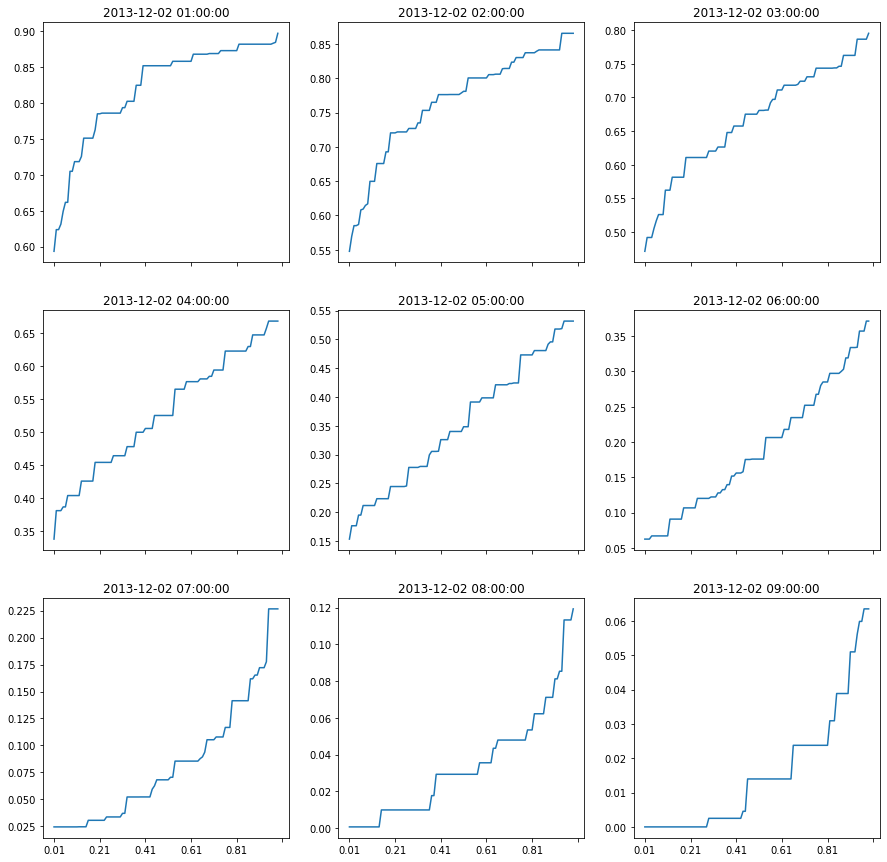

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, sharex=True, figsize=(15, 15))

for i in range(9):
    prediction.iloc[i].tail(99).plot(ax=ax[i // 3, i % 3],
                                     title=str(yq_output_df[-24*30:].index[i]))

# Evaluate Loss

The loss function is the pinnball loss:
$$ L(q_a, y) = \begin{cases}
    (1-\frac{a}{100})(q_a - y), &\text{if } y < q_a \\
    \frac{a}{100}(y-q_a), &\text{if } y \geq q_a.
\end{cases} $$

The score is then averaged over all target quantiles for all time periods over the forecast horizon and for all zones.

In [18]:
def pinnball_loss(actual, prediction):
    actual = actual[...,None]

    percentiles = np.empty((actual.shape[0], 99))
    for i in range(1, 100):
        percentiles[:, i-1] = i
    loss = np.where(actual < prediction,
                    (1 - percentiles / 100) * (prediction - actual),
                    percentiles / 100 * (actual - prediction))
    return loss

In [19]:
test_ts = np.squeeze(train_data1[-gefcom14_metadata['prediction_length']:].values)
loss = np.mean(pinnball_loss(test_ts, prediction))

print(f"Loss of task {task} with NNQF: {round(loss, 5)}")

Loss of task 10 with NNQF: 0.02438
